## Using Linear models (from `sklearn.linear_model`) on crypto price trend prediction

In [1]:
# Preliminary code needed for importing from parent directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

# Import Karan's data API
from data import series

import numpy as np

# This classifier first converts the target values into {-1, 1} and then treats the problem as a regression task
# (multi-output regression in the multiclass case).
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Define a function to generate X, y from raw data (Use Karan's data API)

In [2]:
def gen_X_y(symbol: str, timeframe: str):
    # Create a series for BTC-USDT pair on 1h candles
    # btc = series.DataSeries('BTCUSDT', '1h')
    btc = series.DataSeries(symbol, timeframe)
    data = btc.getData()
    # print(data.keys())

    price_close = data['close']
    # print(len(price_close))
    
    prev5 = np.concatenate([
            # pivot timeframe
            price_close[np.newaxis, 5:],
            # previous 5 timeframes
            price_close[np.newaxis, 4:-1], # 1 frame ago
            price_close[np.newaxis, 3:-2], # 2 frame ago
            price_close[np.newaxis, 2:-3], # 3 frame ago
            price_close[np.newaxis, 1:-4], # 4 frame ago
            price_close[np.newaxis, :-5],  # 5 frame ago
        ],
        axis = 0
    )

    # Generate truth values (y)
    y = prev5[0, :] > np.amin(prev5[1:, :], axis = 0)
    print('timeframe:', timeframe)
    print('number of times where trend is up: ', y[y == True].shape)
    print('number of times where trend is down: ', y[y == False].shape)
    
    btc.addIndicator('RSI', data['close'], 30) # 30-timeframe RSI

    btc.addIndicator('EMA', data['close'], 30) # 30-timeframe EMA
    # btc1h.addIndicator('EMA', btc1h.getData()['close'], 50) # 50-timeframe EMA

    ## MFI: https://www.investopedia.com/terms/m/mfi.asp
    btc.addIndicator('MFI', data['high'], data['low'], data['close'], data['volume'], 10) # 10-timeframe MFI

    
    btc.addIndicator('ADX', data['high'], data['low'], data['close'], 14)
    btc.addIndicator('SMA', data['close'], 30)
    # ATR - Average True Range
    btc.addIndicator('ATR', data['high'], data['low'], data['close'], 14) # 14-timeframe ATR
    
    ## MACD: https://www.investopedia.com/terms/m/macd.asp
    btc.addIndicator('MACD', data['close'], 12, 26) # fast = 12, slow = 26

    indicators = btc.getIndicators()
    #for indicator in indicators.keys():
        #print(indicator)
        
    time_cut = 50

    # Each technical indicator consists one column of X.
    X = np.concatenate(
        (
            indicators['RSI'][np.newaxis, time_cut:].T,
            indicators['EMA'][np.newaxis, time_cut:].T,
            indicators['MFI'][np.newaxis, time_cut:].T
        ),
        axis = 1
    )
    # print('shape of X:', X.shape)
    # print('shape of y:', y.shape)

    y_truncate = y[(time_cut - 5):]
    
    return (X, y_truncate)

## Generate X, y from 1h-scale data

In [3]:
X_h, y_h = gen_X_y('BTCUSDT', '1h')

# Split train/test sets
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h)
print('X, y generated from 1h-scale data')
print('train set size:', y_train_h.shape)
print('test set size:', y_test_h.shape)

timeframe: 1h
number of times where trend is up:  (24655,)
number of times where trend is down:  (6013,)
X, y generated from 1h-scale data
train set size: (22967,)
test set size: (7656,)


## Generate X, y from 1d-scale data

In [4]:
X_d, y_d = gen_X_y('BTCUSDT', '1d')

# Split train/test sets
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d)
print('X, y generated from 1d-scale data')
print('train set size:', y_train_d.shape)
print('test set size:', y_test_d.shape)

timeframe: 1d
number of times where trend is up:  (1039,)
number of times where trend is down:  (239,)
X, y generated from 1d-scale data
train set size: (924,)
test set size: (309,)


## Ridge Classifier

Accuracy of Ridge Classifier (on 1h-scale data)
training set accuracy: 0.8066791483432751
test set accuracy: 0.8025078369905956


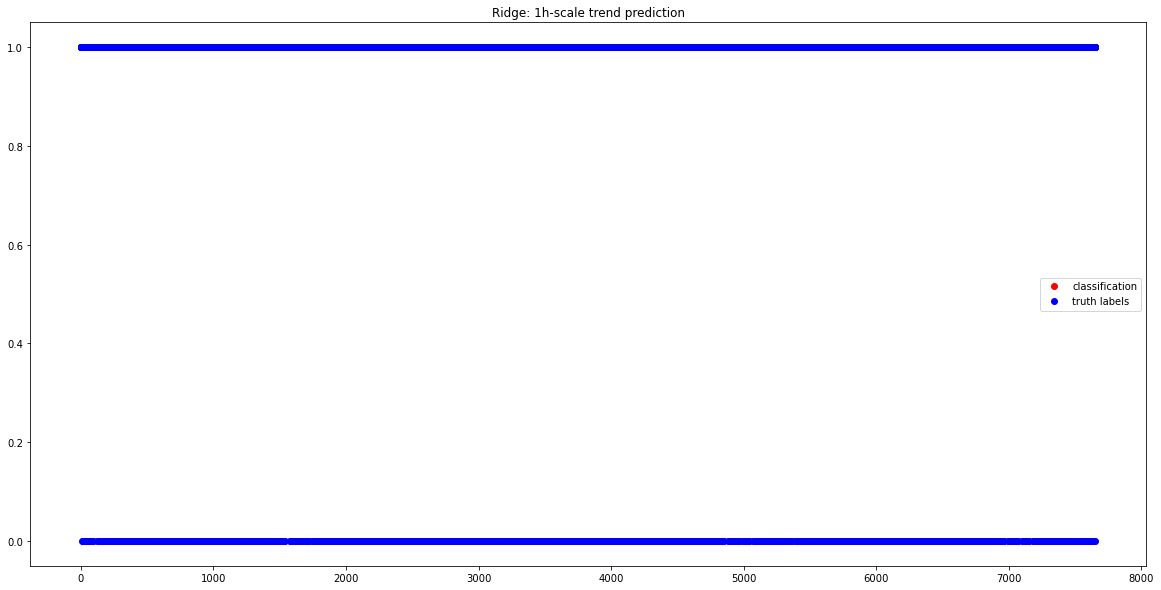

In [5]:
ridge_clf_h = RidgeClassifier().fit(X_train_h, y_train_h)

print('Accuracy of Ridge Classifier (on 1h-scale data)')
print('training set accuracy:', ridge_clf_h.score(X_train_h, y_train_h))
print('test set accuracy:', ridge_clf_h.score(X_test_h, y_test_h))
# print('test set accuracy:', accuracy_score(y_test_h, ridge_clf.predict(X_test_h))) # Exact same result as above
plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test_h.shape[0]), ridge_clf_h.predict(X_test_h), 'ro', label = "classification")
plt.plot(np.arange(X_test_h.shape[0]), y_test_h, 'bo', label = "truth labels")
plt.title('Ridge: 1h-scale trend prediction')
plt.legend()
plt.show()

Accuracy of Ridge Classifier (on 1d-scale data)
training set accuracy: 0.7997835497835498
test set accuracy: 0.8478964401294499


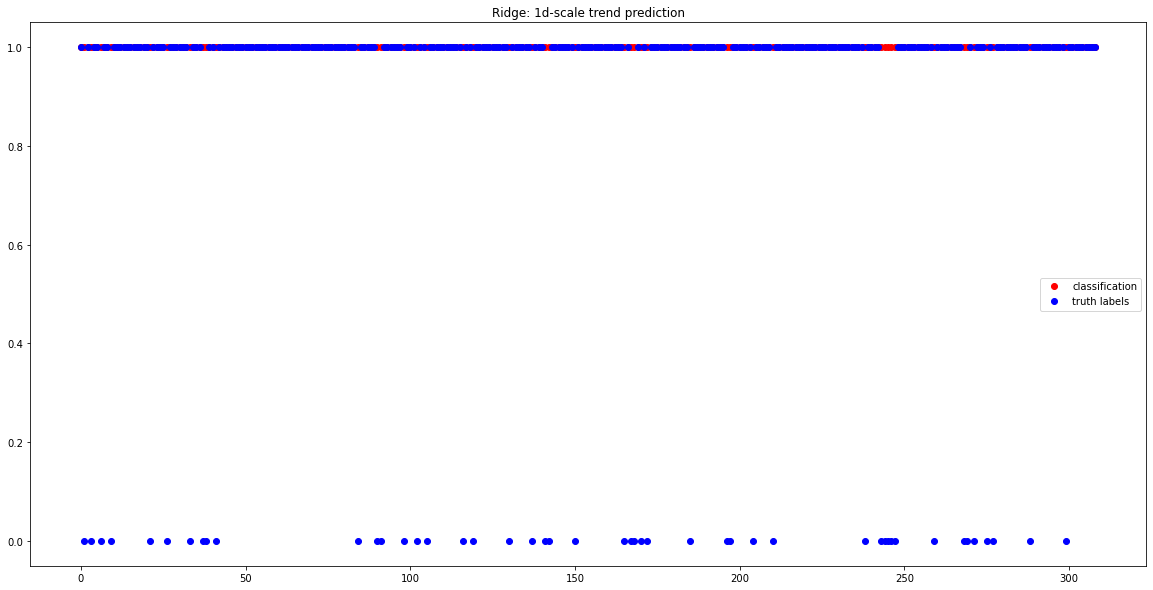

In [6]:
ridge_clf_d = RidgeClassifier().fit(X_train_d, y_train_d)

print('Accuracy of Ridge Classifier (on 1d-scale data)')
print('training set accuracy:', ridge_clf_d.score(X_train_d, y_train_d))
print('test set accuracy:', ridge_clf_d.score(X_test_d, y_test_d))

plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test_d.shape[0]), ridge_clf_d.predict(X_test_d), 'ro', label = "classification")
plt.plot(np.arange(X_test_d.shape[0]), y_test_d, 'bo', label = "truth labels")
plt.title('Ridge: 1d-scale trend prediction')
plt.legend()
plt.show()

## Logistic Regression

Accuracy of Logistic Regression (on 1h-scale data)
training set accuracy: 0.8050246005137807
test set accuracy: 0.8013322884012539


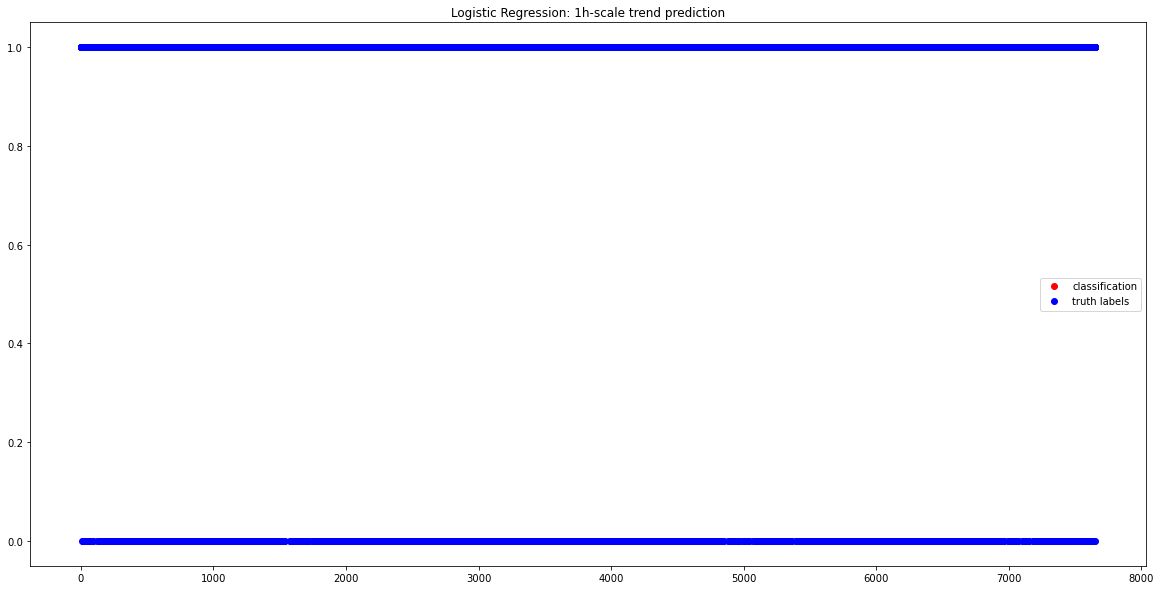

In [7]:
logi_clf_h = LogisticRegression(random_state=0).fit(X_train_h, y_train_h)

print('Accuracy of Logistic Regression (on 1h-scale data)')
print('training set accuracy:', logi_clf_h.score(X_train_h, y_train_h))
print('test set accuracy:', logi_clf_h.score(X_test_h, y_test_h))

plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test_h.shape[0]), logi_clf_h.predict(X_test_h), 'ro', label = "classification")
plt.plot(np.arange(X_test_h.shape[0]), y_test_h, 'bo', label = "truth labels")
plt.title('Logistic Regression: 1h-scale trend prediction')
plt.legend()
plt.show()

Accuracy of Logistic Regression (on 1d-scale data)
training set accuracy: 0.7987012987012987
test set accuracy: 0.8478964401294499


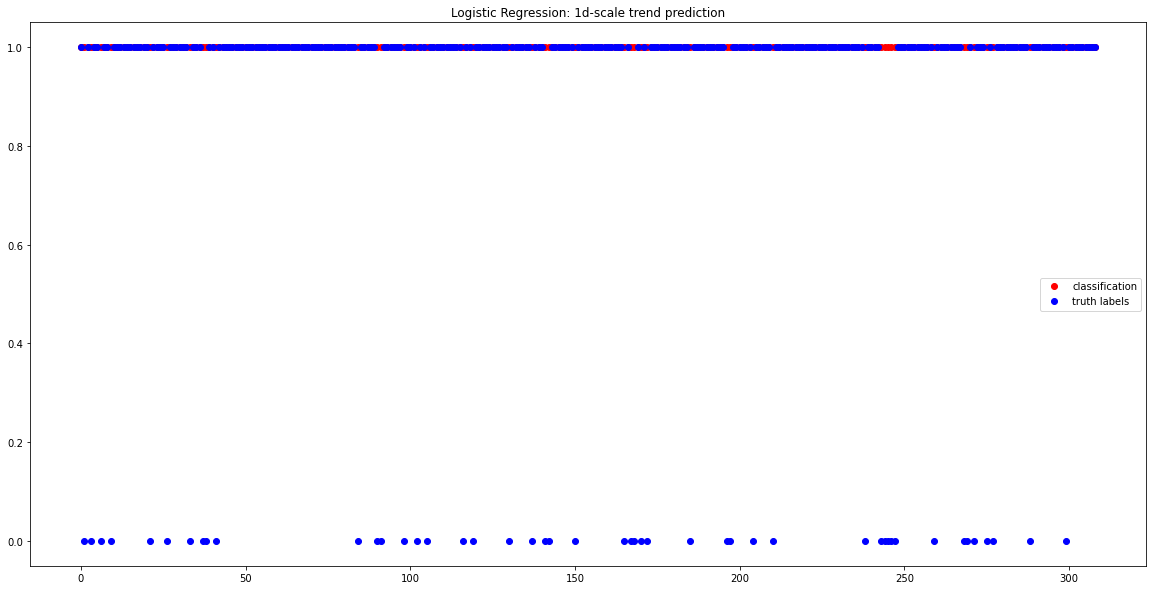

In [8]:
logi_clf_d = LogisticRegression(random_state=0).fit(X_train_d, y_train_d)

print('Accuracy of Logistic Regression (on 1d-scale data)')
print('training set accuracy:', logi_clf_d.score(X_train_d, y_train_d))
print('test set accuracy:', logi_clf_d.score(X_test_d, y_test_d))

plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test_d.shape[0]), logi_clf_d.predict(X_test_d), 'ro', label = "classification")
plt.plot(np.arange(X_test_d.shape[0]), y_test_d, 'bo', label = "truth labels")
plt.title('Logistic Regression: 1d-scale trend prediction')
plt.legend()
plt.show()

According to the above results from `Ridge Classifier` & `Logistic Regression`, these **linear** models are working quite well on the price data.

### The problem is that our dataset itself is skewed (in terms of the Truth label ratio). 80% or above consists of `True` labels for the `BUY` signal (whether we use `1h` scale or `1d` scale price data). We need to try training the classifiers using a dataset that consists of roughly 50% of `True` labels..

## Let's try training the linear models with data that have 50/50 rate of True/False labels.

In [9]:
print('hour scale price data')
print('True count:', len(y_h[y_h == True]))
print('False count:', len(y_h[y_h == False]))

indices = np.where(y_h == True)[0]
if len(y_h[y_h == True]) > len(y_h[y_h == False]):
    indices = np.random.choice(indices, size = len(y_h[y_h == False]), replace = False)
else:
    raise NotImplementedError
    
# Combine the `True` indices with `False` indices
indices = np.concatenate((indices, np.where(y_h == False)[0]))

X_train_h_even, X_test_h_even, y_train_h_even, y_test_h_even = train_test_split(X_h[indices], y_h[indices])
print('Train set True/False ratio:', len(np.where(y_train_h_even == True)[0]), '/', len(np.where(y_train_h_even == False)[0]))
print('Test set True/False ratio:', len(np.where(y_test_h_even == True)[0]), '/', len(np.where(y_test_h_even == False)[0]))

ridge_clf_h_even = RidgeClassifier().fit(X_train_h_even, y_train_h_even)

print('Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', ridge_clf_h_even.score(X_train_h_even, y_train_h_even))
print('test set accuracy:', ridge_clf_h_even.score(X_test_h_even, y_test_h_even))

hour scale price data
True count: 24621
False count: 6002
Train set True/False ratio: 4513 / 4490
Test set True/False ratio: 1489 / 1512
Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.6520048872598023
test set accuracy: 0.6667777407530823


In [10]:
print('day scale price data')
print('True count:', len(y_d[y_d == True]))
print('False count:', len(y_d[y_d == False]))

indices = np.where(y_d == True)[0]
if len(y_d[y_d == True]) > len(y_d[y_d == False]):
    indices = np.random.choice(indices, size = len(y_d[y_d == False]), replace = False)
else:
    raise NotImplementedError
    
# Combine the `True` indices with `False` indices
indices = np.concatenate((indices, np.where(y_d == False)[0]))

X_train_d_even, X_test_d_even, y_train_d_even, y_test_d_even = train_test_split(X_d[indices], y_d[indices])
print('Total dataset size (train + test):', indices.shape[0])
print('Train set True/False ratio:', len(np.where(y_train_d_even == True)[0]), '/', len(np.where(y_train_d_even == False)[0]))
print('Test set True/False ratio:', len(np.where(y_test_d_even == True)[0]), '/', len(np.where(y_test_d_even == False)[0]))

ridge_clf_d_even = RidgeClassifier().fit(X_train_d_even, y_train_d_even)

print('Accuracy of Ridge Classifier (on 1d-scale data, 50/50 dataset)')
print('training set accuracy:', ridge_clf_d_even.score(X_train_d_even, y_train_d_even))
print('test set accuracy:', ridge_clf_d_even.score(X_test_d_even, y_test_d_even))

day scale price data
True count: 1000
False count: 233
Total dataset size (train + test): 466
Train set True/False ratio: 177 / 172
Test set True/False ratio: 56 / 61
Accuracy of Ridge Classifier (on 1d-scale data, 50/50 dataset)
training set accuracy: 0.6762177650429799
test set accuracy: 0.7435897435897436


In [11]:
logi_clf_h_even = LogisticRegression(random_state=0).fit(X_train_h_even, y_train_h_even)
print('Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', logi_clf_h_even.score(X_train_h_even, y_train_h_even))
print('test set accuracy:', logi_clf_h_even.score(X_test_h_even, y_test_h_even), end = '\n\n')

logi_clf_d_even = LogisticRegression(random_state=0).fit(X_train_d_even, y_train_d_even)
print('Accuracy of Logistic Regression (on 1d-scale data, 50/50 dataset)')
print('training set accuracy:', logi_clf_d_even.score(X_train_d_even, y_train_d_even))
print('test set accuracy:', logi_clf_d_even.score(X_test_d_even, y_test_d_even))

Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.6533377762967899
test set accuracy: 0.6661112962345884

Accuracy of Logistic Regression (on 1d-scale data, 50/50 dataset)
training set accuracy: 0.6303724928366762
test set accuracy: 0.6068376068376068


## Polynomial regression (linear models with polynomial features)

In [12]:
from sklearn.preprocessing import PolynomialFeatures

In [13]:
poly = PolynomialFeatures(2)

X_train_h_even_poly = poly.fit_transform(X_train_h_even)
X_test_h_even_poly = poly.fit_transform(X_test_h_even)

X_train_d_even_poly = poly.fit_transform(X_train_d_even)
X_test_d_even_poly = poly.fit_transform(X_test_d_even)



ridge_clf_h_even_poly = RidgeClassifier().fit(X_train_h_even_poly, y_train_h_even)
print('Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', ridge_clf_h_even_poly.score(X_train_h_even_poly, y_train_h_even))
print('test set accuracy:', ridge_clf_h_even_poly.score(X_test_h_even_poly, y_test_h_even), end = '\n\n')

ridge_clf_d_even_poly = RidgeClassifier().fit(X_train_d_even_poly, y_train_d_even)
print('Accuracy of Ridge Classifier (on 1d-scale data, 50/50 dataset)')
print('training set accuracy:', ridge_clf_d_even_poly.score(X_train_d_even_poly, y_train_d_even))
print('test set accuracy:', ridge_clf_d_even_poly.score(X_test_d_even_poly, y_test_d_even), end = '\n\n')

logi_clf_h_even_poly = LogisticRegression(random_state=0).fit(X_train_h_even_poly, y_train_h_even)
print('Accuracy of Polynomial Logistic Regression (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', logi_clf_h_even_poly.score(X_train_h_even_poly, y_train_h_even))
print('test set accuracy:', logi_clf_h_even_poly.score(X_test_h_even_poly, y_test_h_even), end = '\n\n')

logi_clf_d_even_poly = LogisticRegression(random_state=0).fit(X_train_d_even_poly, y_train_d_even)
print('Accuracy of Polynomial Logistic Regression (on 1d-scale data, 50/50 dataset)')
print('training set accuracy:', logi_clf_d_even_poly.score(X_train_d_even_poly, y_train_d_even))
print('test set accuracy:', logi_clf_d_even_poly.score(X_test_d_even_poly, y_test_d_even))

Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.6520048872598023
test set accuracy: 0.6664445184938353

Accuracy of Ridge Classifier (on 1d-scale data, 50/50 dataset)
training set accuracy: 0.6905444126074498
test set accuracy: 0.7264957264957265

Accuracy of Polynomial Logistic Regression (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.601910474286349
test set accuracy: 0.6014661779406865

Accuracy of Polynomial Logistic Regression (on 1d-scale data, 50/50 dataset)
training set accuracy: 0.6561604584527221
test set accuracy: 0.7264957264957265


/home/lonelyjoe/.local/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.23823e-21): result may not be accurate.
  overwrite_a=True).T
/home/lonelyjoe/.local/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.47245e-20): result may not be accurate.
  overwrite_a=True).T


## Checking **stationarity** of each feature, and apply time-differencing for non-stationary features

* `Augmented Dickey-Fuller test (ADF)`
  * ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.

    * Null Hypotehsis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
    * Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
    * p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
    * p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary
  * Source: https://medium.com/@kangeugine/time-series-check-stationarity-1bee9085da05

In [14]:
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller test

In [15]:
# Create a series for BTC-USDT pair on 1h candles
symbol = 'BTCUSDT'
timeframe = '1h'

btc = series.DataSeries(symbol, timeframe)
data = btc.getData()
# print(data.keys())

price_close = data['close']
# print(len(price_close))

prev5 = np.concatenate([
        # pivot timeframe
        price_close[np.newaxis, 5:],
        # previous 5 timeframes
        price_close[np.newaxis, 4:-1], # 1 frame ago
        price_close[np.newaxis, 3:-2], # 2 frame ago
        price_close[np.newaxis, 2:-3], # 3 frame ago
        price_close[np.newaxis, 1:-4], # 4 frame ago
        price_close[np.newaxis, :-5],  # 5 frame ago
    ],
    axis = 0
)

# Generate truth values (y)
y = prev5[0, :] > np.amin(prev5[1:, :], axis = 0)
print('timeframe:', timeframe)
print('number of times where trend is up: ', y[y == True].shape)
print('number of times where trend is down: ', y[y == False].shape)

btc.addIndicator('RSI', data['close'], 30) # 30-timeframe RSI

btc.addIndicator('EMA', data['close'], 30) # 30-timeframe EMA
# btc1h.addIndicator('EMA', btc1h.getData()['close'], 50) # 50-timeframe EMA

## MFI: https://www.investopedia.com/terms/m/mfi.asp
btc.addIndicator('MFI', data['high'], data['low'], data['close'], data['volume'], 10) # 10-timeframe MFI

## MACD: https://www.investopedia.com/terms/m/macd.asp
btc.addIndicator('MACD', data['close'], 12, 26) # fast = 12, slow = 26

btc.addIndicator('ADX', data['high'], data['low'], data['close'], 14)
btc.addIndicator('SMA', data['close'], 30)
# ATR - Average True Range
btc.addIndicator('ATR', data['high'], data['low'], data['close'], 14) # 14-timeframe ATR

indicators = btc.getIndicators()
#for indicator in indicators.keys():
    #print(indicator)
    
time_cut = 50

timeframe: 1h
number of times where trend is up:  (24655,)
number of times where trend is down:  (6013,)


In [16]:
## Check stationarity of `RSI` feature

result = adfuller(indicators['RSI'][time_cut:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print('\nAccept H0, the data has a unit root and is non-stationary')
else:
    print('\nReject H0. the data does not have a unit root and is stationary')

ADF Statistic: -16.199904
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Reject H0. the data does not have a unit root and is stationary


In [17]:
## Check stationarity of 'EMA' feature

result = adfuller(indicators['EMA'][time_cut:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print('\nAccept H0, the data has a unit root and is non-stationary')
else:
    print('\nReject H0. the data does not have a unit root and is stationary')

ADF Statistic: 6.354036
p-value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Accept H0, the data has a unit root and is non-stationary


In [18]:
## It seems that the 'EMA' feature is not stationary..
## Let's attempt time-differencing on `EMA` feature, in order to make it stationary.

# Time differencing.
# Note that time-differencing by K results in the length of the data series be reduced by K.
indicators['EMA_td'] = np.diff(indicators['EMA'][time_cut:])
print(indicators['EMA'][time_cut:].shape, indicators['EMA_td'].shape)

result = adfuller(indicators['EMA_td'][time_cut:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print('\nAccept H0, the data has a unit root and is non-stationary')
else:
    print('\nReject H0. the data does not have a unit root and is stationary')

(30623,) (30622,)
ADF Statistic: -19.361763
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Reject H0. the data does not have a unit root and is stationary


In [19]:
## Check stationarity of 'MFI' feature

result = adfuller(indicators['MFI'][time_cut:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print('\nAccept H0, the data has a unit root and is non-stationary')
else:
    print('\nReject H0. the data does not have a unit root and is stationary')

ADF Statistic: -22.818716
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Reject H0. the data does not have a unit root and is stationary


In [20]:
time_cut = 50 + 1 # (+1) is due to the time-differencing applied to 'EMA' feature.

# Each technical indicator consists one column of X.
X = np.concatenate(
    (
        indicators['RSI'][np.newaxis, time_cut:].T,
        indicators['EMA_td'][np.newaxis, :].T,
        indicators['MFI'][np.newaxis, time_cut:].T
    ),
    axis = 1
)
# print('shape of X:', X.shape)
# print('shape of y:', y.shape)

y_trunc = y[(time_cut - 5):]

print(X.shape, y_trunc.shape)

(30622, 3) (30622,)


In [21]:
## Checking stationarity of `BUY` signal (`y`)

result = adfuller(y_trunc)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print('\nAccept H0, the data has a unit root and is non-stationary')
else:
    print('\nReject H0. the data does not have a unit root and is stationary')

ADF Statistic: -33.791866
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Reject H0. the data does not have a unit root and is stationary


In [22]:
print('hour scale price data')
print('True count:', len(y_trunc[y_trunc == True]))
print('False count:', len(y_trunc[y_trunc == False]))

indices = np.where(y_trunc == True)[0]
if len(y_trunc[y_trunc == True]) > len(y_trunc[y_trunc == False]):
    indices = np.random.choice(indices, size = len(y_trunc[y_trunc == False]), replace = False)
else:
    raise NotImplementedError
    
# Combine the `True` indices with `False` indices
indices = np.concatenate((indices, np.where(y_trunc == False)[0]))

X_train_h_even, X_test_h_even, y_train_h_even, y_test_h_even = train_test_split(X[indices], y_trunc[indices])
print('Train set True/False ratio:', len(np.where(y_train_h_even == True)[0]), '/', len(np.where(y_train_h_even == False)[0]))
print('Test set True/False ratio:', len(np.where(y_test_h_even == True)[0]), '/', len(np.where(y_test_h_even == False)[0]))

ridge_clf_h_even = RidgeClassifier().fit(X_train_h_even, y_train_h_even)

print()
print('Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', ridge_clf_h_even.score(X_train_h_even, y_train_h_even))
print('test set accuracy:', ridge_clf_h_even.score(X_test_h_even, y_test_h_even), end = '\n\n')

logi_clf_h_even = LogisticRegression(random_state=0).fit(X_train_h_even, y_train_h_even)
print('Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', logi_clf_h_even.score(X_train_h_even, y_train_h_even))
print('test set accuracy:', logi_clf_h_even.score(X_test_h_even, y_test_h_even), end = '\n\n')

hour scale price data
True count: 24621
False count: 6001
Train set True/False ratio: 4539 / 4462
Test set True/False ratio: 1462 / 1539

Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.6657038106877013
test set accuracy: 0.6551149616794402

Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.6697033662926342
test set accuracy: 0.6587804065311563



## Before/After PCA

In [26]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import StandardScaler

def gen_X_y_with_more(symbol: str, timeframe: str):
    # Create a series for BTC-USDT pair on 1h candles
    # btc = series.DataSeries('BTCUSDT', '1h')
    btc = series.DataSeries(symbol, timeframe)
    data = btc.getData()
    # print(data.keys())

    price_close = data['close']
    # print(len(price_close))
    
    prev5 = np.concatenate([
            # pivot timeframe
            price_close[np.newaxis, 5:],
            # previous 5 timeframes
            price_close[np.newaxis, 4:-1], # 1 frame ago
            price_close[np.newaxis, 3:-2], # 2 frame ago
            price_close[np.newaxis, 2:-3], # 3 frame ago
            price_close[np.newaxis, 1:-4], # 4 frame ago
            price_close[np.newaxis, :-5],  # 5 frame ago
        ],
        axis = 0
    )

    # Generate truth values (y)
    y = prev5[0, :] > np.amin(prev5[1:, :], axis = 0)
    print('timeframe:', timeframe)
    print('number of times where trend is up: ', y[y == True].shape)
    print('number of times where trend is down: ', y[y == False].shape)
    
    btc.addIndicator('RSI', data['close'], 30) # 30-timeframe RSI

    btc.addIndicator('EMA', data['close'], 30) # 30-timeframe EMA
    # btc1h.addIndicator('EMA', btc1h.getData()['close'], 50) # 50-timeframe EMA

    ## MFI: https://www.investopedia.com/terms/m/mfi.asp
    btc.addIndicator('MFI', data['high'], data['low'], data['close'], data['volume'], 10) # 10-timeframe MFI

    
    btc.addIndicator('ADX', data['high'], data['low'], data['close'], 14)
    btc.addIndicator('SMA', data['close'], 30)
    # ATR - Average True Range
    btc.addIndicator('ATR', data['high'], data['low'], data['close'], 14) # 14-timeframe ATR
    
    ## MACD: https://www.investopedia.com/terms/m/macd.asp
    btc.addIndicator('MACD', data['close'], 12, 26) # fast = 12, slow = 26

    indicators = btc.getIndicators()
    #for indicator in indicators.keys():
        #print(indicator)
        
    time_cut = 50

    # Each technical indicator consists one column of X.
    X = np.concatenate(
        (
            indicators['RSI'][np.newaxis, time_cut:].T,
            indicators['EMA'][np.newaxis, time_cut:].T,
            indicators['MFI'][np.newaxis, time_cut:].T,
            indicators['SMA'][np.newaxis, time_cut:].T,
            indicators['ADX'][np.newaxis, time_cut:].T,
            indicators['ATR'][np.newaxis, time_cut:].T,
        ),
        axis = 1
    )
    # print('shape of X:', X.shape)
    # print('shape of y:', y.shape)

    y_truncate = y[(time_cut - 5):]
    
    return (X, y_truncate)

In [27]:
X_new, y_new = gen_X_y_with_more('BTCUSDT', '1h')

indices = np.where(y_new == True)[0]
if len(y_new[y_new == True]) > len(y_new[y_new == False]):
    indices = np.random.choice(indices, size = len(y_new[y_new == False]), replace = False)
else:
    raise NotImplementedError
    
# Combine the `True` indices with `False` indices
indices = np.concatenate((indices, np.where(y_new == False)[0]))

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new[indices], y_new[indices])
print('Train set True/False ratio:', len(np.where(y_train_h_even == True)[0]), '/', len(np.where(y_train_h_even == False)[0]))
print('Test set True/False ratio:', len(np.where(y_test_h_even == True)[0]), '/', len(np.where(y_test_h_even == False)[0]))
print()

ridge_clf_new = RidgeClassifier().fit(X_train_new, y_train_new)
print('Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', ridge_clf_new.score(X_train_new, y_train_new))
print('test set accuracy:', ridge_clf_new.score(X_test_new, y_test_new), end = '\n\n')

logi_clf_new = LogisticRegression(random_state=0).fit(X_train_new, y_train_new)
print('Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', logi_clf_new.score(X_train_new, y_train_new))
print('test set accuracy:', logi_clf_new.score(X_test_new, y_test_new), end = '\n\n')

timeframe: 1h
number of times where trend is up:  (24655,)
number of times where trend is down:  (6013,)
Train set True/False ratio: 4539 / 4462
Test set True/False ratio: 1462 / 1539

Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.6602243696545596
test set accuracy: 0.6411196267910696

Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.6109074752860157
test set accuracy: 0.6091302899033656



## Try similar experiment, but with StandardScaling as preprocssing step

In [28]:
X_new, y_new = gen_X_y_with_more('BTCUSDT', '1h')

pipeline = Pipeline([
    ('scaling', StandardScaler()),
    # ('pca', PCA(n_components=pca_n))
])

indices = np.where(y_new == True)[0]
if len(y_new[y_new == True]) > len(y_new[y_new == False]):
    indices = np.random.choice(indices, size = len(y_new[y_new == False]), replace = False)
else:
    raise NotImplementedError
    
# Combine the `True` indices with `False` indices
indices = np.concatenate((indices, np.where(y_new == False)[0]))

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    pipeline.fit_transform(X_new[indices]),
    y_new[indices]
)

print('Train set True/False ratio:', len(np.where(y_train_h_even == True)[0]), '/', len(np.where(y_train_h_even == False)[0]))
print('Test set True/False ratio:', len(np.where(y_test_h_even == True)[0]), '/', len(np.where(y_test_h_even == False)[0]))
print()

ridge_clf_new = RidgeClassifier().fit(X_train_new, y_train_new)
print('Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', ridge_clf_new.score(X_train_new, y_train_new))
print('test set accuracy:', ridge_clf_new.score(X_test_new, y_test_new), end = '\n\n')

logi_clf_new = LogisticRegression(random_state=0).fit(X_train_new, y_train_new)
print('Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', logi_clf_new.score(X_train_new, y_train_new))
print('test set accuracy:', logi_clf_new.score(X_test_new, y_test_new), end = '\n\n')

timeframe: 1h
number of times where trend is up:  (24655,)
number of times where trend is down:  (6013,)
Train set True/False ratio: 4539 / 4462
Test set True/False ratio: 1462 / 1539

Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.6550038875930245
test set accuracy: 0.6654448517160947

Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.6556703321115184
test set accuracy: 0.6651116294568478



## PCA (Unsupervised Learning)

In [29]:
from sklearn.svm import SVC

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import StandardScaler

In [30]:
# Pipeline of standardization & PCA
# pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=5))])

# pipeline.fit_transform(data)

# Try PCA with 'different # of principal components'
for pca_n in range(1, X_new.shape[1]):
    pipeline = Pipeline([
        # ('scaling', StandardScaler()),
        ('pca', PCA(n_components=pca_n))
    ])
    
    X_pca = pipeline.fit_transform(X_new)
    
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca[indices], y_new[indices])
    
    ridge_clf_pca = RidgeClassifier().fit(X_train_pca, y_train_pca)
    print('Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset, after PCA:{})'.format(pca_n))
    print('training set accuracy:', ridge_clf_pca.score(X_train_pca, y_train_pca))
    print('test set accuracy:', ridge_clf_pca.score(X_test_pca, y_test_pca), end = '\n\n')

    logi_clf_pca = LogisticRegression(random_state=0).fit(X_train_pca, y_train_pca)
    print('Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset, after PCA:{})'.format(pca_n))
    print('training set accuracy:', logi_clf_pca.score(X_train_pca, y_train_pca))
    print('test set accuracy:', logi_clf_pca.score(X_test_pca, y_test_pca), end = '\n\n')
    
    # SVM
    for kernel_kind in ['poly', 'rbf', 'sigmoid']:
        svm = SVC(kernel = kernel_kind).fit(X_train_pca, y_train_pca)
        
        print('Accuracy of SVM({}) Classifier (on 1h-scale data, 50/50 dataset, after PCA:{})'.format(kernel_kind, pca_n))
        print('training set accuracy:', svm.score(X_train_pca, y_train_pca))
        print('test set accuracy:', svm.score(X_test_pca, y_test_pca), end = '\n\n')

Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset, after PCA:1)
training set accuracy: 0.5039431300677552
test set accuracy: 0.48817060979673443

Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset, after PCA:1)
training set accuracy: 0.5117183161168499
test set accuracy: 0.493835388203932

Accuracy of SVM(poly) Classifier (on 1h-scale data, 50/50 dataset, after PCA:1)
training set accuracy: 0.5042763523270021
test set accuracy: 0.4895034988337221

Accuracy of SVM(rbf) Classifier (on 1h-scale data, 50/50 dataset, after PCA:1)
training set accuracy: 0.5216039098078419
test set accuracy: 0.5118293902032656

Accuracy of SVM(sigmoid) Classifier (on 1h-scale data, 50/50 dataset, after PCA:1)
training set accuracy: 0.5093857603021215
test set accuracy: 0.48350549816727756

Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset, after PCA:2)
training set accuracy: 0.5068310563145618
test set accuracy: 0.49250249916694433

Accuracy of Logistic Regression (on 1h-

In [33]:
# Pipeline of standardization & PCA
# pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=5))])

# pipeline.fit_transform(data)

# Try PCA with 'different # of principal components'
for pca_n in range(1, X_new.shape[1]):
    pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ('pca', PCA(n_components=pca_n))
    ])
    
    X_pca = pipeline.fit_transform(X_new)
    
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca[indices], y_new[indices])
    
    ridge_clf_pca = RidgeClassifier().fit(X_train_pca, y_train_pca)
    print('Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset, after PCA:{})'.format(pca_n))
    print('training set accuracy:', ridge_clf_pca.score(X_train_pca, y_train_pca))
    print('test set accuracy:', ridge_clf_pca.score(X_test_pca, y_test_pca), end = '\n\n')

    logi_clf_pca = LogisticRegression(random_state=0).fit(X_train_pca, y_train_pca)
    print('Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset, after PCA:{})'.format(pca_n))
    print('training set accuracy:', logi_clf_pca.score(X_train_pca, y_train_pca))
    print('test set accuracy:', logi_clf_pca.score(X_test_pca, y_test_pca), end = '\n\n')
    
    # SVM
    for kernel_kind in ['poly', 'rbf', 'sigmoid']:
        svm = SVC(kernel = kernel_kind).fit(X_train_pca, y_train_pca)
        
        print('Accuracy of SVM({}) Classifier (on 1h-scale data, 50/50 dataset, after PCA:{})'.format(kernel_kind, pca_n))
        print('training set accuracy:', svm.score(X_train_pca, y_train_pca))
        print('test set accuracy:', svm.score(X_test_pca, y_test_pca), end = '\n\n')

Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset, after PCA:1)
training set accuracy: 0.5123847606353438
test set accuracy: 0.5161612795734755

Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset, after PCA:1)
training set accuracy: 0.5123847606353438
test set accuracy: 0.5161612795734755

Accuracy of SVM(poly) Classifier (on 1h-scale data, 50/50 dataset, after PCA:1)
training set accuracy: 0.5012773519937799
test set accuracy: 0.49883372209263577

Accuracy of SVM(rbf) Classifier (on 1h-scale data, 50/50 dataset, after PCA:1)
training set accuracy: 0.5199377985116073
test set accuracy: 0.5151616127957348

Accuracy of SVM(sigmoid) Classifier (on 1h-scale data, 50/50 dataset, after PCA:1)
training set accuracy: 0.5066089081417305
test set accuracy: 0.5078307230923026

Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset, after PCA:2)
training set accuracy: 0.6536709985560368
test set accuracy: 0.6541152949016994

Accuracy of Logistic Regression (on 1h-s

### Notes on results from applying PCA & StandardScaler
* Applying StandardScaler to features seems to accuracy of the linear classifiers by a small amount (~1%)
* Applying PCA doesn't seem to improve accuracy of the linear classifiers

In [32]:
import backtrader as bt
import datetime
import matplotlib

def init_cerebro_with_data(datapath):
    cerebro = bt.Cerebro()
    # docs on how to set parameters properly to parse .csv files:
    # https://www.backtrader.com/docu/datafeed/
    data = bt.feeds.GenericCSVData(
        dataname=datapath,
        fromdate=datetime.datetime(2017, 8, 18),
        todate=datetime.datetime(2021, 3, 6),
        # Following args are column indices
        datetime=1,
        time=-1,
        open=4,
        high=5,
        low=6,
        close=7,
        volume=8,
        dtformat="%Y-%m-%d"
    )
    cerebro.adddata(data)
    return cerebro

class RSIStrategy(bt.Strategy):
    def __init__(self):
        self.rsi = bt.talib.RSI(self.data, period=14)
        # print(vars(self.rsi))
        print(type(self.data))
    def next(self):
        if self.rsi >= 60 and not self.position:
            self.buy(size=1)
        if self.rsi < 60 and self.position:
            self.close()

def run_backtest(datapath):
    cerebro = init_cerebro_with_data(datapath)
    cerebro.addstrategy(RSIStrategy)

    print('Starting portfolio value: $%.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final portfolio value: $%.2f' % cerebro.broker.getvalue())
    cerebro.plot()


if __name__ == '__main__':
    # run_backtest('../decision_tree/csvs/rev_Binance_BTCUSDT_d.csv')
    run_backtest('../decision_tree/csvs/rev_Binance_BTCUSDT_1h.csv')

SyntaxError: invalid syntax (<ipython-input-32-3b1e108ffd59>, line 49)